# Exploring the relationship between SLR and extreme weather events in Indonesia

## Presets

In [4]:
# loading the libraries
import s3fs
import random
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import pooch
import tempfile
import cartopy.crs as ccrs
import holoviews
from geoviews import Dataset as gvDataset
import geoviews.feature as gf
from geoviews import Image as gvImage
import boto3
import botocore
from pythia_datasets import DATASETS
from scipy import stats

ModuleNotFoundError: No module named 's3fs'

In [5]:
# @title Helper functions
def pooch_load(filelocation=None, filename=None, processor=None):
    shared_location = "/home/jovyan/shared/data/tutorials/W1D3_RemoteSensingLandOceanandAtmosphere"  # this is different for each day
    user_temp_cache = tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location, filename)):
        file = os.path.join(shared_location, filename)
    else:
        file = pooch.retrieve(
            filelocation,
            known_hash=None,
            fname=os.path.join(user_temp_cache, filename),
            processor=processor,
        )

    return file

In [6]:
#Loading data
# load the sea surface height data from ECCO and select area covering Indonesia
url_ECCO='~/shared/Data/Projects/Sea_Level/SEA_SURFACE_HEIGHT_mon_mean_1992-01-2017-12_ECCO_V4r4_latlon_0p50deg.nc'
ds_ssh=xr.open_dataset(url_ECCO)
ssh=ds_ssh["SSH"]
ssh=ssh.sel(latitude=slice(minlat, maxlat), longitude=slice(minlon, maxlon))
# take a closer look at the data
ssh

NameError: name 'xr' is not defined

### Indonesia coordinates

In [14]:
# defining coordinates to cover the extent of Indonesia
minlat=-14
maxlat=10
minlon=89
maxlon=142

## Contents

- Investigating SLR trends using satellite data (ECCO)

## Investigating SLR Trends in Indonesia (ECCO data)

In [16]:
# take a closer look at the data
ssh

<xarray.DataArray 'SSH' (time: 312, latitude: 48, longitude: 106)>
[1587456 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
  * latitude   (latitude) float32 -13.75 -13.25 -12.75 -12.25 ... 8.75 9.25 9.75
  * longitude  (longitude) float32 89.25 89.75 90.25 90.75 ... 140.8 141.2 141.8
Attributes:
    long_name:              Dynamic sea surface height anomaly
    valid_max:              1.4207719564437866
    standard_name:          sea_surface_height_above_geoid
    coverage_content_type:  modelResult
    comment:                Dynamic sea surface height anomaly above the geoi...
    units:                  m
    valid_min:              -1.8805772066116333

### SSH (sea surface height) data over the period 1992-2017

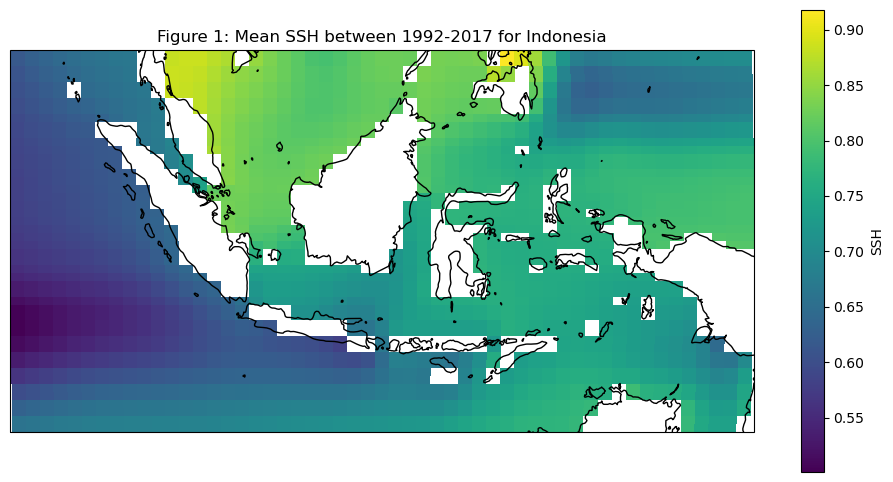

In [17]:
# calculate the mean sea surface height across all years available - the data starts from 1992
ssh_mean=ssh.mean("time")

# plot mean sea level across years, just to see what the data looks like
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=110))
ssh_mean.plot(transform=ccrs.PlateCarree(), ax=ax)
plt.title("Figure 1: Mean SSH between 1992-2017 for Indonesia")

# add coastlines
ax.coastlines()

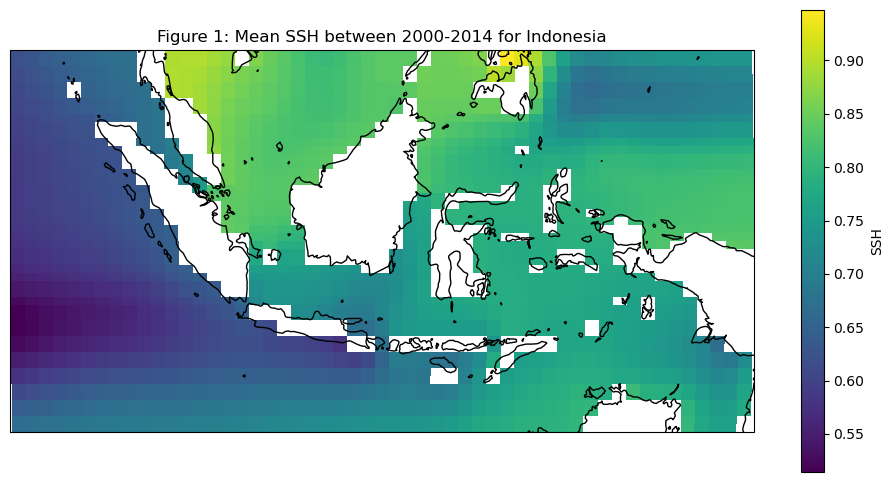

In [18]:
#plot mean sea level across years, just to see what the data looks like
#calculate the mean sea surface height across all years available - the data starts from 1992
ssh_mean=ssh.sel(time=slice("2000-01-01", "2014-01-01")).mean(dim="time")

#plotting the mean ssh across all data available
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=110))
ssh_mean.plot(transform=ccrs.PlateCarree(), ax=ax)

plt.title("Figure 1: Mean SSH between 2000-2014 for Indonesia")

# add coastlines
ax.coastlines()

### Interpretation
Figure 1 shows the mean sea surface height (SSH) over Indonesia between 1992 - 2017. We see that the highest SSH is in north (east) Indonesia at 0.9m. The lowest SSH is in the west at 0.55m. The white pixels represent the landmass. As we can see, the coast lines and landmass do not match neatly. This demonstrates the limits in the spatial resolution of the model, demonstrating it is fairly coarse when looking at island nations. 

## SSH Anomalies

In [19]:
# calculate the difference between mean SSH and year-wise mean SSH
ssh_year=ssh.groupby("time.year").mean()

# calculate the mean anomaly per year
ssh_anomaly=ssh_year-ssh_mean
ssh_anomaly

<xarray.DataArray 'SSH' (year: 26, latitude: 48, longitude: 106)>
array([[[-0.0307709 , -0.0307709 , -0.0307681 , ..., -0.0940848 ,
                 nan,         nan],
        [-0.0307709 , -0.0307709 , -0.0307681 , ..., -0.0940848 ,
                 nan,         nan],
        [-0.04176039, -0.04176039, -0.04162318, ..., -0.09629416,
         -0.08764815, -0.08764815],
        ...,
        [-0.02867091, -0.02867091, -0.02776486, ..., -0.14974207,
         -0.14722085, -0.14722085],
        [-0.02662218, -0.02662218, -0.02622378, ..., -0.16326976,
         -0.16144282, -0.16144282],
        [-0.02662218, -0.02662218, -0.02622378, ..., -0.16326976,
         -0.16144282, -0.16144282]],

       [[-0.020895  , -0.020895  , -0.02342635, ..., -0.11350572,
                 nan,         nan],
        [-0.020895  , -0.020895  , -0.02342635, ..., -0.11350572,
                 nan,         nan],
        [-0.02409697, -0.02409697, -0.02641195, ..., -0.11916447,
         -0.11693257, -0.11693257],
...
        [ 0.07109892,  0.07109892,  0.07420731, ..., -0.0243991 ,
         -0.02266949, -0.02266949],
        [ 0.07555515,  0.07555515,  0.07836998, ..., -0.04851347,
         -0.04687512, -0.04687512],
        [ 0.07555515,  0.07555515,  0.07836998, ..., -0.04851347,
         -0.04687512, -0.04687512]],

       [[ 0.0355798 ,  0.0355798 ,  0.03311253, ...,  0.03548896,
                 nan,         nan],
        [ 0.0355798 ,  0.0355798 ,  0.03311253, ...,  0.03548896,
                 nan,         nan],
        [ 0.03542048,  0.03542048,  0.03367317, ...,  0.03323269,
          0.02956039,  0.02956039],
        ...,
        [ 0.0209583 ,  0.0209583 ,  0.02679998, ...,  0.07666332,
          0.07595718,  0.07595718],
        [ 0.01982707,  0.01982707,  0.02693218, ...,  0.06743085,
          0.06634301,  0.06634301],
        [ 0.01982707,  0.01982707,  0.02693218, ...,  0.06743085,
          0.06634301,  0.06634301]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -13.75 -13.25 -12.75 -12.25 ... 8.75 9.25 9.75
  * longitude  (longitude) float32 89.25 89.75 90.25 90.75 ... 140.8 141.2 141.8
  * year       (year) int64 1992 1993 1994 1995 1996 ... 2014 2015 2016 2017

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
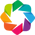

:HoloMap   [year]
   :Overlay
      .Image.I     :Image   [longitude,latitude]   (SSH)
      .Coastline.I :Feature   [Longitude,Latitude]

In [20]:
# plot the mean anomaly in ssh across years as an animation
holoviews.extension("bokeh")
dataset_plot = gvDataset(
    ssh_anomaly
)  # only the first 10, as it is a time consuming task
images = dataset_plot.to(gvImage, ["longitude", "latitude"], ["SSH"], "year")
images.opts(
    cmap="BrBG",
    colorbar=True,
    width=600,
    height=400,
    projection=ccrs.Robinson(),
    clabel="Yearly SSH Anomaly \n(mm/day)",
    title="Change in SSH anomaly between 1992-2017 over Indonesia",
) * gf.coastline

### Interpretation
SSH anomaly is increasing over time. Similar to the Figure above, the greatest SLR over time occurs in the north east. 

Text(0.5, 1.0, 'January anomaly mean over Indonesia (1992-2017)')

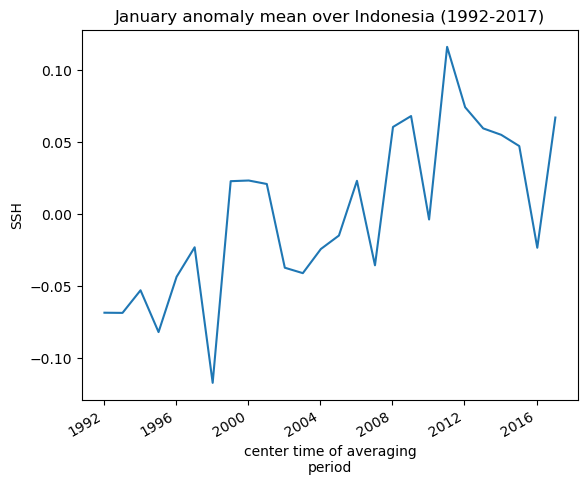

In [21]:
# calculate january climatology and anomaly
ssh_month = ssh.groupby('time.month')
ssh_month_mean = ssh_month.mean(dim='time')
ssh_jan_clim = ssh_month_mean[0].mean(dim=['latitude', 'longitude'])
ssh_jan = ssh_month[1].mean(dim=['latitude', 'longitude'])
ssh_jan_anomaly = ssh_jan - ssh_jan_clim
ssh_jan_anomaly.plot()
plt.title("January anomaly mean over Indonesia (1992-2017)")

### Interpretation
This figure shows the variation of SSH in January. We can see that there are some months where SSH is lower. This could be due to climatic phenomena like ENSO. 

Text(0.5, 1.0, 'July (summer) anomaly mean over Indonesia (1992-2017)')

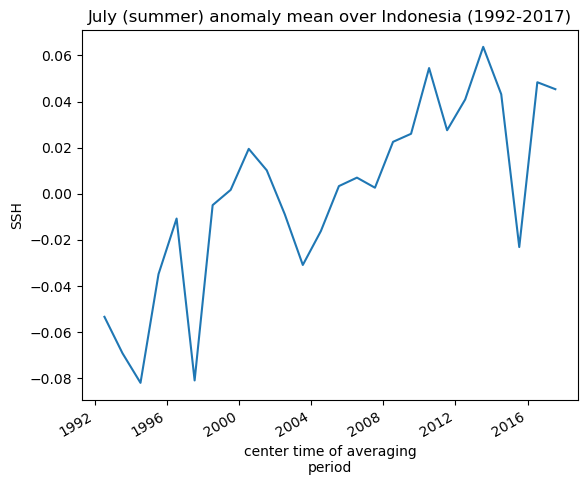

In [22]:
# calculate july climatology and anomaly
ssh_jul_clim = ssh_month_mean[6].mean(dim=['latitude', 'longitude'])
ssh_jul = ssh_month[7].mean(dim=['latitude', 'longitude'])
ssh_jul_anomaly = ssh_jul - ssh_jul_clim
ssh_jul_anomaly.plot()
plt.title("July (summer) anomaly mean over Indonesia (1992-2017)")

## Investigating TOS in Indonesia (CESM2 data)

In [23]:
# load the tos data and select area covering Indonesia
filepath = DATASETS.fetch("CESM2_sst_data.nc")
ds_tos = xr.open_dataset(filepath)
ds_tos
tos = ds_tos.tos.sel(lat = slice(minlat, maxlat
), lon = slice(minlon, maxlon))

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [24]:
# take a closer look at the data
tos

<xarray.DataArray 'tos' (time: 180, lat: 24, lon: 53)>
[228960 values with dtype=float32]
Coordinates:
  * time     (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat      (lat) float64 -13.5 -12.5 -11.5 -10.5 -9.5 ... 5.5 6.5 7.5 8.5 9.5
  * lon      (lon) float64 89.5 90.5 91.5 92.5 93.5 ... 138.5 139.5 140.5 141.5
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    This may differ from "surface temperature" in regions of ...
    frequency:      mon
    id:             tos
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Surface Temperature
    type:           real
    units:          degC
    variable_id:    tos

### TOS (temperature ocean surface) over the data period (2000-2014)

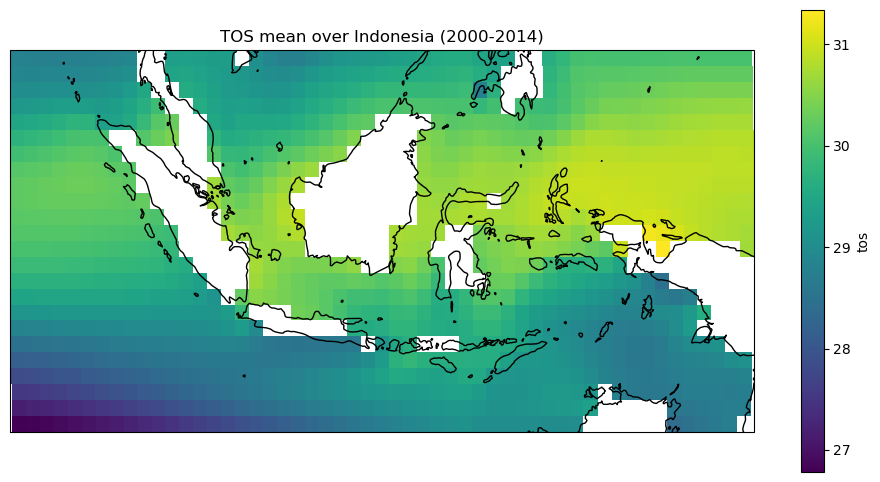

In [25]:
# calculate the mean sea surface temperature across all years available - the data ranges from 2000 to 2014 and has a monthly resolution
tos_mean=tos.mean("time")

# plot mean sea surface temperature across years, just to see what the data looks like
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=110))
tos_mean.plot(transform=ccrs.PlateCarree(), ax=ax)
plt.title("TOS mean over Indonesia (2000-2014)")

# add coastlines
ax.coastlines()

In [26]:
# calculate the difference between mean TOS across years and year-wise mean TOS
tos_year=tos.groupby("time.year").mean()

# calculate the mean anomaly per year
tos_anomaly = tos_year - tos_mean
tos_anomaly

<xarray.DataArray 'tos' (year: 15, lat: 24, lon: 53)>
array([[[ 0.29546928,  0.29356384,  0.2890072 , ..., -0.14078903,
         -0.12506866,         nan],
        [ 0.33236122,  0.3351879 ,  0.33363533, ..., -0.15391159,
         -0.1215744 , -0.10777473],
        [ 0.33642578,  0.34391785,  0.34536362, ..., -0.17716408,
         -0.14362144, -0.12714577],
        ...,
        [-0.26838303, -0.30256844, -0.3301792 , ..., -0.17197037,
         -0.15747261, -0.14878845],
        [-0.25761223, -0.3004284 , -0.3374195 , ..., -0.16254616,
         -0.14739609, -0.13831139],
        [-0.24176598, -0.28172302, -0.31812286, ..., -0.13006783,
         -0.12035942, -0.1162014 ]],

       [[-0.06253433, -0.0854187 , -0.10972023, ..., -0.46549606,
         -0.44579697,         nan],
        [-0.08794212, -0.10780907, -0.12948799, ..., -0.49694443,
         -0.49826813, -0.5414734 ],
        [-0.12565804, -0.14401054, -0.16542053, ..., -0.5272541 ,
         -0.528389  , -0.5507622 ],
...
        [ 0.32169724,  0.32570267,  0.3383026 , ...,  0.05172157,
          0.04499245,  0.03937912],
        [ 0.35328102,  0.35347748,  0.36577606, ..., -0.00297737,
         -0.00128174,  0.00432587],
        [ 0.38174438,  0.37466812,  0.38101387, ..., -0.05425453,
         -0.03281593, -0.01400566]],

       [[-0.12234879, -0.13237   , -0.14121246, ...,  0.4289055 ,
          0.41965866,         nan],
        [-0.14312744, -0.1517353 , -0.15777016, ...,  0.44125748,
          0.43886757,  0.4324646 ],
        [-0.14536858, -0.1545105 , -0.16117096, ...,  0.46144485,
          0.45518494,  0.45874977],
        ...,
        [-0.00368881,  0.00800133,  0.01688385, ...,  0.43149948,
          0.44503975,  0.4576893 ],
        [-0.07790565, -0.06950188, -0.05965614, ...,  0.4138317 ,
          0.42232513,  0.42794228],
        [-0.13365555, -0.12966537, -0.11884499, ...,  0.41207504,
          0.41457176,  0.42243767]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -13.5 -12.5 -11.5 -10.5 -9.5 ... 5.5 6.5 7.5 8.5 9.5
  * lon      (lon) float64 89.5 90.5 91.5 92.5 93.5 ... 138.5 139.5 140.5 141.5
  * year     (year) int64 2000 2001 2002 2003 2004 ... 2010 2011 2012 2013 2014

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
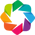

:HoloMap   [year]
   :Overlay
      .Image.I     :Image   [lon,lat]   (tos)
      .Coastline.I :Feature   [Longitude,Latitude]

In [27]:
# plot the mean anomaly in tos across years as an animation
holoviews.extension("bokeh")
dataset_plot = gvDataset(
tos_anomaly
)
images = dataset_plot.to(gvImage, ["longitude", "latitude"], ["tos"], "year")
images.opts(
    cmap="BrBG",
    colorbar=True,
    width=600,
    height=400,
    projection=ccrs.Robinson(),
    clabel="Yearly TOS Anomaly \n(deg C)",
    title="Change in TOS between 2000-2014 over Indonesia",
) * gf.coastline

### Interpretation
This shows us that like SSH, TOS anomalies are increasing and shifting over time (averaged across all months/years). In the early 2000s the anomaly is negative, especially over the west. In the mid 2000s, the TOS increases up to 1 deg C and becomes stronger in the east. 

Text(0.5, 1.0, 'Jan (winter) TOS anomaly over Indonesia (2000-2014)')

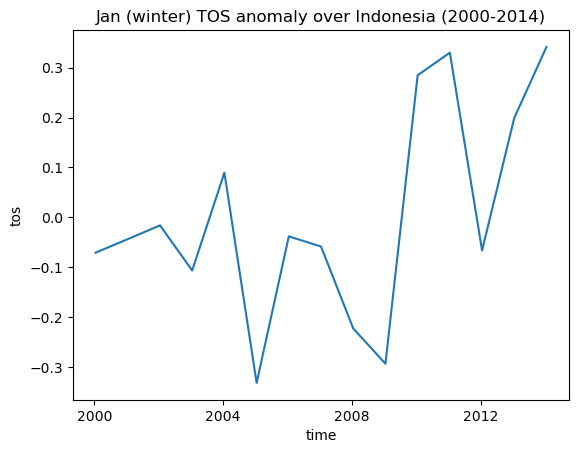

In [28]:
# calculate january climatology and anomaly
tos_month = tos.groupby('time.month')
tos_month_mean = tos_month.mean(dim='time')
tos_jan_clim = tos_month_mean[0].mean(dim=['lat', 'lon'])
tos_jan = tos_month[1].mean(dim=['lat', 'lon'])
tos_jan_anomaly = tos_jan - tos_jan_clim
tos_jan_anomaly.plot()
plt.title("Jan (winter) TOS anomaly over Indonesia (2000-2014)")

Text(0.5, 1.0, 'July (summer) TOS anomaly over Indonesia (2000-2014)')

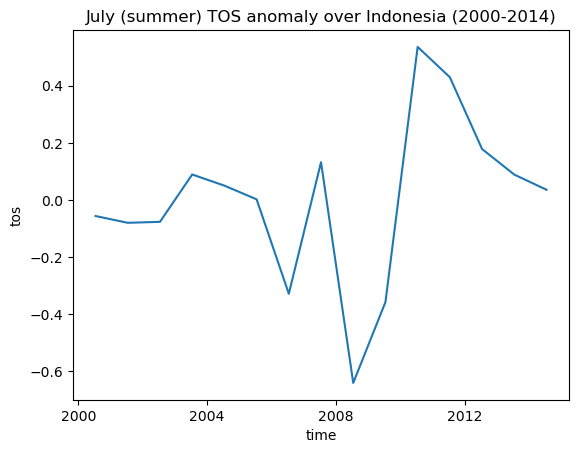

In [29]:
#calculate july climatology and anomaly
tos_jul_clim = tos_month_mean[6].mean(dim=['lat','lon'])
tos_jul = tos_month[7].mean(dim=['lat','lon'])
tos_jul_anomaly = tos_jul - tos_jul_clim
tos_jul_anomaly.plot()
plt.title("July (summer) TOS anomaly over Indonesia (2000-2014)")

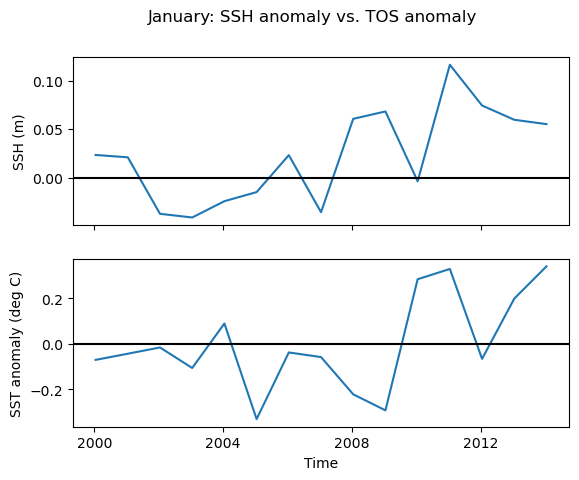

In [30]:
#plotting ssh and tos for january
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle("January: SSH anomaly vs. TOS anomaly")
axs[0].plot(tos_jan_anomaly.time, ssh_jan_anomaly[8:-3])
axs[0].set_ylabel("SSH (m)")
axs[0].axhline(y=0, color="k", linestyle="-")
axs[1].plot(
    tos_jan_anomaly.time, tos_jan_anomaly)
axs[1].set_ylabel("SST anomaly (deg C)")
axs[1].set_xlabel("Time")
axs[1].axhline(y=0, color="k", linestyle="-")

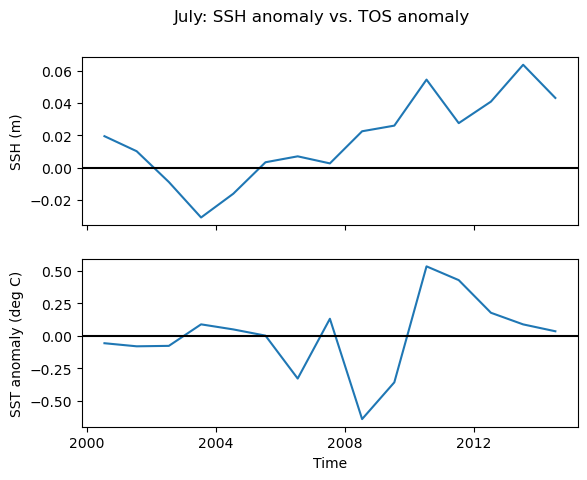

In [31]:
#plotting ssh and tos for july
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle("July: SSH anomaly vs. TOS anomaly")
axs[0].plot(tos_jul_anomaly.time, ssh_jul_anomaly[8:-3])
axs[0].set_ylabel("SSH (m)")
axs[0].axhline(y=0, color="k", linestyle="-")
axs[1].plot(
    tos_jul_anomaly.time, tos_jul_anomaly)
axs[1].set_ylabel("SST anomaly (deg C)")
axs[1].set_xlabel("Time")
axs[1].axhline(y=0, color="k", linestyle="-")

In [32]:
#Pearsons correlation coefficient for SSH and TOS - january
ssh_tos_r, ssh_tos_p = stats.pearsonr(ssh_jan_anomaly[8:-3], tos_jan_anomaly)
print("SSH-TOS Corr Coef: " + str(ssh_tos_r) + ", p-val: " + str(ssh_tos_p))

SSH-TOS Corr Coef: 0.25144547912862675, p-val: 0.36599199229053625


In [33]:
#Pearsons correlation coefficient for SSH and TOS - july
ssh_tos_r, ssh_tos_p = stats.pearsonr(ssh_july_anomaly[8:-3], tos_july_anomaly)
print("SSH-TOS Corr Coef: " + str(ssh_tos_r) + ", p-val: " + str(ssh_tos_p))

type: name 'ssh_july_anomaly' is not defined

### Inference: Relationship between SSH and TOS
For mean values of SSH and TOS across the extent of Indonesia, there does not seem to be any relationship between these variables for data from January and July. Perhaps the relationship between TOS and SSH is strongest at the poles, where increase in TOS leads to melting of ice, resulting in a significant increase in SSH. Since Indonesia is closer to the equator, maybe increase in TOS is not reflected as much in the volumetric expansion of the ocean in this region. This may mean that increase in TOS may not lead to significant volumetric expansion of the ocean in this region.

## Investigating Precipitation for Indonesia (NOAA)

In [6]:
# connect to the AWS S3 bucket for the GPCP Monthly Precipitation CDR data
fs = s3fs.S3FileSystem(anon=True)

# get the list of all data files in the AWS S3 bucket
file_pattern = "noaa-cdr-precip-gpcp-monthly-pds/data/*/gpcp_v02r03_monthly_*.nc"
file_location = fs.glob(file_pattern)

# open connection to all data files
client = boto3.client(
    "s3", config=botocore.client.Config(signature_version=botocore.UNSIGNED)
)  # initialize aws s3 bucket client
file_ob = [
    pooch_load(filelocation="http://s3.amazonaws.com/" + file, filename=file)
    for file in file_location
]

type: name 'pooch_load' is not defined

In [ ]:
# open all the monthly data files and concatenate them along the time dimension
# this process will take ~ 1 minute to complete due to the number of data files
ds_precip = xr.open_mfdataset(file_ob, combine="nested", concat_dim="time")

# comment for colab users only: this could toss an error message for you. 
# you should still be able to use the dataset with this error just not print ds
# you can try uncommenting the following line to avoid the error
# ds.attrs['history']='' # the history attribute have unique chars that cause a crash on Google colab. 
ds_precip

In [ ]:
# load precipitation data for the extent of Indonesia
precip = ds_precip.precip.sel(latitude=slice(minlat, maxlat), longitude=slice(minlon, maxlon))
precip

In [ ]:
# calculate the mean precipitation across all years available - the data ranges from 1979 to 2023 and has a monthly resolution
precip_mean = precip.mean("time")

# plot mean precipitation across years, just to see what the data looks like
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=110))
precip_mean.plot(transform=ccrs.PlateCarree(), ax=ax)

# add coastlines
ax.coastlines()

### Interpretation
This shows us that the precipitation averaged over time occurs in specific hotspots. The highest precipitation occurs in central Indonesia and eastern Indonesia, specifically in Western/Central Kalimantan in and Western Papua New Guinea. 

In [ ]:
# calculate the difference between mean precipitation across years and year-wise mean precipitation
precip_year = precip.groupby("time.year").mean()

# calculate the mean anomaly per year
precip_anomaly = precip_year - precip_mean
precip_anomaly

In [ ]:
# plot the mean anomaly in precipitation across years as an animation
holoviews.extension("bokeh")
dataset_plot = gvDataset(
precip_anomaly.sel(year=slice("1992", "2017")) #there is data over many years, so selecting a few overlapping with the other variables to plot in the animation
)
images = dataset_plot.to(gvImage, ["longitude", "latitude"], ["precip"], "year")
images.opts(
    cmap="BrBG",
    colorbar=True,
    width=600,
    height=400,
    projection=ccrs.Robinson(),
    clabel="Yearly Precipitation Anomaly \n(mm/day)",
) * gf.coastline

In [ ]:
# calculate the precipitation climatology year-wise
precip_clim = precip.groupby("time.year").mean()
precip_clim = precip_clim.mean(dim=["latitude","longitude"])
precip_clim_mean = precip.mean(dim="time").mean(dim=["latitude","longitude"])
precip_clim_anomaly = precip_clim - precip_clim_mean #subtract the clim
precip_clim_anomaly.plot()

In [ ]:
# calculate january climatology and anomaly
precip_month = precip.groupby('time.month')
precip_month_mean = precip_month.mean(dim='time')
precip_jan_clim = precip_month_mean[0].mean(dim=['latitude', 'longitude'])
precip_jan = precip_month[1].mean(dim=['latitude', 'longitude'])
precip_jan_anomaly = precip_jan - precip_jan_clim
precip_jan_anomaly.plot()


In [ ]:
# calculate july climatology and anomaly
precip_jul_clim = precip_month_mean[6].mean(dim=['latitude', 'longitude'])
precip_jul = precip_month[7].mean(dim=['latitude', 'longitude'])
precip_jul_anomaly = precip_jul - precip_jul_clim
precip_jul_anomaly.plot()

In [ ]:
# set up two subplots that share the x-axis to compare monthly precipitation and monthly anomaly - January
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle("January: SSH anomaly vs. Precipitation anomaly")
axs[0].plot(ssh_jan_anomaly.time, ssh_jan_anomaly)
axs[0].set_ylabel("SSH (m)")
axs[0].axhline(y=0, color="k", linestyle="-")
axs[1].plot(precip_jan_anomaly[13:-6].time, precip_jan_anomaly[13:-6])
axs[1].set_ylabel("Precipitation anomaly (mm/day)")
axs[1].set_xlabel("Time")
axs[1].axhline(y=0, color="k", linestyle="-")

In [ ]:
# set up two subplots that share the x-axis to compare monthly precipitation and monthly anomaly - July
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle("July: SSH anomaly vs. Precipitation anomaly")
axs[0].plot(ssh_jul_anomaly.time, ssh_july_anomaly)
axs[0].set_ylabel("SSH (m)")
axs[0].axhline(y=0, color="k", linestyle="-")
axs[1].plot(precip_jul_anomaly[13:-6].time, precip_jul_anomaly[13:-6])
axs[1].set_ylabel("Precipitation anomaly (mm/day)")
axs[1].set_xlabel("Time")
axs[1].axhline(y=0, color="k", linestyle="-")

In [ ]:
#finding the correlation between these two variables
ssh_precip_jan_r, ssh_precip_jan_p = stats.pearsonr(ssh_jan_anomaly, precip_jan_anomaly[13:-6])
print("SSH-Precip Corr Coef: " + str(ssh_precip_jan_r) + ", p-val: " + str(ssh_precip_jan_p))

In [ ]:
#finding the correlation between these two variables
ssh_precip_jul_r, ssh_precip_jul_p = stats.pearsonr(ssh_jul_anomaly, precip_jul_anomaly[13:-5])
print("SSH-Precip Corr Coef: " + str(ssh_precip_jul_r) + ", p-val: " + str(ssh_precip_jul_p))

## Tidal guage data (UHSLC)

In [ ]:
# download tidal guage data for Bitung 
bitung = "https://uhslc.soest.hawaii.edu/data/netcdf/fast/daily/d033.nc"

# example code after downloading tidal gauge data:
ds_bitung = xr.open_dataset(
    pooch.retrieve(bitung, known_hash=None)
)  # this is just an example, tidal gauge NetCDF file needs to be downloaded in order to load this.

ds_bitung

In [ ]:
# URLS for daily data for locations spread out across Indonesia
loc={'Pandang': 'https://uhslc.soest.hawaii.edu/data/netcdf/fast/daily/d107.nc',
                          'Bitung': 'https://uhslc.soest.hawaii.edu/data/netcdf/fast/daily/d033.nc',
                          'Sabang': 'https://uhslc.soest.hawaii.edu/data/netcdf/fast/daily/d123.nc',
                          'Prigi': 'https://uhslc.soest.hawaii.edu/data/netcdf/fast/daily/d125.nc',
                          'Ambon': 'https://uhslc.soest.hawaii.edu/data/netcdf/fast/daily/d133.nc',
                          'Lembar': 'https://uhslc.soest.hawaii.edu/data/netcdf/fast/daily/d419.nc'
                         }

In [ ]:
# run a loop to save the data for all the locations and assign approporiate variable names
# takes the global variables so that we can assign the name "ds_<enter location>" to each data set
my_var=globals()
ds_list = []
# loop through the dictionary of chosen locations to assign the netcdf data to each name and store it in global variables
for k,v in loc.items():
    my_var["ds_"+k.lower()] = xr.open_dataset(
    pooch.retrieve(v, known_hash=None)
    )
    ds_list.append(eval(("ds_"+k.lower()))) #creates a list for sea level datasets for future use
ds_list

In [ ]:
# calculate the monthly mean between a time period for the region
# we can see that the sea level differs greatly from summer to winter seasons
ds_list_mean= []
ax = plt.axes()
for i, key in enumerate(loc): #i represents the loop count and key is the name of the location.
    my_var[key.lower()+"_mean"]=(
    ds_list[i].sel(time=slice("2008-10-02", "2021-12-11")).sea_level.groupby('time.year').mean()
    )
    ds_list_mean.append(eval(key.lower()+"_mean")) #creates a list for mean sea level over time for future use
    eval(key.lower()+"_mean").plot(ax=ax, label = key) #plots mean for each location
    
ax.legend()

In [ ]:
# look at the mean tidal height values for Bitung and Prigi between 2008 and 2022, just to see what the data looks like
bitung_mean = (
    ds_bitung.sea_level.sel(time=slice("2008", "2022"))
    .groupby("time.month")
    .mean(dim="time")
)
bitung_mean.plot()

prigi_mean = (
    ds_prigi.sea_level.sel(time=slice("2008", "2022"))
    .groupby("time.month")
    .mean(dim="time")
)
bitung_mean.plot()
prigi_mean.plot()

In [ ]:
# data comparison between SSH and Tidal Gauge data
ssh_bitung=ssh.sel(latitude=1.48, longitude=125.55,method = "nearest")
ssh_bitung=ssh_bitung.groupby("time.year").mean().sel(year=slice("2008", "2014"))
tide_bitung = (ds_bitung.sea_level.sel(time=slice("2008", "2014")).groupby("time.year").mean()/1000).squeeze()

tide_bitung.plot()
ssh_bitung.plot()

In [ ]:
# correlation between tidal guage data for Bitung and SSH data for Bitung
bitung_ssh_r, bitung_ssh_p = stats.pearsonr(tide_bitung, ssh_bitung)
print("bitung_ssh_ Corr Coef: " + str(bitung_ssh_r) + ", p-val: " + str(bitung_ssh_p))

In [ ]:
# fill missing data in the tidal guage time series across locations
# calculate the correlation between tidal heights across locations and print results
ffilled_datasets = [x.ffill(dim="time") for x in ds_list]
keys = list(loc)
for i, a in enumerate(keys):  
    keys.remove(a)
    for j, b in enumerate(keys):
        r,p=stats.pearsonr(ffilled_datasets[i].sea_level.sel(time=slice("2008-10-02", "2021-12-11")).squeeze(), ffilled_datasets[j].sea_level.sel(time=slice("2008-10-02", "2021-12-11")).squeeze())
        print(a,b,r,p)

In [ ]:
# calculate the jan climatology for pandang tidal data
monthly_data = ds_pandang.sea_level.sel(time=slice('2005', '2014')).resample(time='1M').mean(dim='time').squeeze()
pandang_sea_level_jan_clim = ds_pandang.sea_level.sel(time=slice("2005", "2014")).groupby("time.month").mean(dim='time').squeeze()[0]/1000
pandang_sea_level_jan = monthly_data.groupby('time.month')[1]/1000
pandang_sea_level_jan_anomaly = pandang_sea_level_jan - pandang_sea_level_jan_clim
pandang_sea_level_jan_anomaly

#look at the temperature anomaly for pandang in jan
tos_pandang=tos.sel(lat= -1.02, lon= 100.38,method = "nearest")
tos_pandang_month = tos_pandang.groupby('time.month')
tos_pandang_month_mean = tos_pandang_month.mean(dim='time')
tos_pandang_jan_clim = tos_pandang_month_mean[0]
tos_pandang_jan = tos_pandang_month[1]
tos_pandang_jan_anomaly = tos_pandang_jan - tos_pandang_jan_clim
tos_pandang_jan_anomaly

#plotting tidal guage data and tos for pandang in january
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle("January: SSH anomaly vs. TOS anomaly Pandang")
axs[0].plot(tos_pandang_jan_anomaly.time[6:15], pandang_sea_level_jan_anomaly)
axs[0].set_ylabel("SSH (m)")
axs[0].axhline(y=0, color="k", linestyle="-")
axs[1].plot(
    tos_pandang_jan_anomaly.time[6:15], tos_pandang_jan_anomaly[6:15])
axs[1].set_ylabel("SST anomaly (deg C)")
axs[1].set_xlabel("Time")
axs[1].axhline(y=0, color="k", linestyle="-")

#Pearsons correlation coefficient for tidal data and TOS - pandang, january
ssh_tos_r, ssh_tos_p = stats.pearsonr(pandang_sea_level_jan_anomaly, tos_pandang_jan_anomaly[6:15])
print("SSH-TOS Corr Coef: " + str(ssh_tos_r) + ", p-val: " + str(ssh_tos_p))

In [ ]:
# calculate the jan climatology for tidal guage data - prigi
monthly_data = ds_prigi.sea_level.sel(time=slice('2005', '2014')).resample(time='1M').mean(dim='time').squeeze()
prigi_sea_level_jan_clim = ds_prigi.sea_level.sel(time=slice("2005", "2014")).groupby("time.month").mean(dim='time').squeeze()[0]/1000
prigi_sea_level_jan = monthly_data.groupby('time.month')[1]/1000
prigi_sea_level_jan_anomaly = prigi_sea_level_jan - prigi_sea_level_jan_clim
prigi_sea_level_jan_anomaly

#look at the temperature anomaly for in january - prigi
tos_prigi = tos.sel(lat= -8.28, lon= 111.72, method = "nearest")
tos_prigi_month = tos_prigi.groupby('time.month')
tos_prigi_month_mean = tos_prigi_month.mean(dim='time')
tos_prigi_jan_clim = tos_prigi_month_mean[0]
tos_prigi_jan = tos_prigi_month[1]
tos_prigi_jan_anomaly = tos_prigi_jan - tos_prigi_jan_clim
tos_prigi_jan_anomaly

#plotting ssh and tos for january - prigi
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle("January: SSH anomaly vs. TOS anomaly Prigi")
axs[0].plot(tos_prigi_jan_anomaly.time[8:15], prigi_sea_level_jan_anomaly)
axs[0].set_ylabel("SSH (m)")
axs[0].axhline(y=0, color="k", linestyle="-")
axs[1].plot(
    tos_prigi_jan_anomaly.time[8:15], tos_prigi_jan_anomaly[8:15])
axs[1].set_ylabel("SST anomaly (deg C)")
axs[1].set_xlabel("Time")
axs[1].axhline(y=0, color="k", linestyle="-")

#Pearsons correlation coefficient for SSH and TOS - prigi, january
ssh_tos_r, ssh_tos_p = stats.pearsonr(prigi_sea_level_jan_anomaly, tos_prigi_jan_anomaly[8:15])
print("SSH-TOS Corr Coef: " + str(ssh_tos_r) + ", p-val: " + str(ssh_tos_p))

In [ ]:
# calculate the jan climatology for bitung tidal guage data 
bitung_sea_level = ds_bitung.sea_level.sel(time=slice('2009', '2014'))
monthly_data = bitung_sea_level.resample(time='1M').mean(dim='time').squeeze()
bitung_sea_level_jan_clim = ds_bitung.sea_level.sel(time=slice("2009", "2014")).groupby("time.month").mean(dim='time').squeeze()[0]/1000
bitung_sea_level_jan = monthly_data.groupby('time.month')[1]/1000
bitung_sea_level_jan_anomaly = bitung_sea_level_jan - bitung_sea_level_jan_clim
bitung_sea_level_jan_anomaly

#look at the temperature anomaly for bitung in january
tos_bitung=tos.sel(lat=1.48, lon=125.55, method = "nearest")
tos_bitung_month = tos_bitung.groupby('time.month')
tos_bitung_month_mean = tos_bitung_month.mean(dim='time')
tos_bitung_jan_clim = tos_bitung_month_mean[0]
tos_bitung_jan = tos_bitung_month[1]
tos_bitung_jan_anomaly = tos_bitung_jan - tos_bitung_jan_clim
tos_bitung_jan_anomaly

#plotting tidal guage data and tos for bitung in january
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle("January: SSH anomaly vs. TOS anomaly Bitung")
axs[0].plot(tos_bitung_jan_anomaly.time[9:15], bitung_sea_level_jan_anomaly)
axs[0].set_ylabel("SSH (m)")
axs[0].axhline(y=0, color="k", linestyle="-")
axs[1].plot(
    tos_bitung_jan_anomaly.time[8:15], tos_bitung_jan_anomaly[8:15])
axs[1].set_ylabel("SST anomaly (deg C)")
axs[1].set_xlabel("Time")
axs[1].axhline(y=0, color="k", linestyle="-")

In [ ]:
# calculate the jan climatology for tidal guage data - sabang
monthly_data = ds_sabang.sea_level.sel(time=slice('2005', '2014')).resample(time='1M').mean(dim='time').squeeze()
sabang_sea_level_jan_clim = ds_sabang.sea_level.sel(time=slice("2005", "2014")).groupby("time.month").mean(dim='time').squeeze()[0]/1000
sabang_sea_level_jan = monthly_data.groupby('time.month')[1]/1000
sabang_sea_level_jan_anomaly = sabang_sea_level_jan - sabang_sea_level_jan_clim
sabang_sea_level_jan_anomaly

#look at the temperature anomaly for in january - sabang
tos_sabang = tos.sel(lat= 5.88, lon= 95.35,method = "nearest")
tos_sabang_month = tos_sabang.groupby('time.month')
tos_sabang_month_mean = tos_sabang_month.mean(dim='time')
tos_sabang_jan_clim = tos_sabang_month_mean[0]
tos_sabang_jan = tos_sabang_month[1]
tos_sabang_jan_anomaly = tos_sabang_jan - tos_sabang_jan_clim
tos_sabang_jan_anomaly

#plotting ssh and tos for january - sabang
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle("January: SSH anomaly vs. TOS anomaly Sabang")
axs[0].plot(tos_sabang_jan_anomaly.time[6:15], sabang_sea_level_jan_anomaly)
axs[0].set_ylabel("SSH (m)")
axs[0].axhline(y=0, color="k", linestyle="-")
axs[1].plot(
    tos_sabang_jan_anomaly.time[6:15], tos_sabang_jan_anomaly[6:15])
axs[1].set_ylabel("SST anomaly (deg C)")
axs[1].set_xlabel("Time")
axs[1].axhline(y=0, color="k", linestyle="-")

In [ ]:
# calculate the jan climatology for tidal guage data - ambon
monthly_data = ds_ambon.sea_level.sel(time=slice('2005', '2014')).resample(time='1M').mean(dim='time').squeeze()
ambon_sea_level_jan_clim = ds_ambon.sea_level.sel(time=slice("2005", "2014")).groupby("time.month").mean(dim='time').squeeze()[0]/1000
ambon_sea_level_jan = monthly_data.groupby('time.month')[1]/1000
ambon_sea_level_jan_anomaly = ambon_sea_level_jan - ambon_sea_level_jan_clim
ambon_sea_level_jan_anomaly

#look at the temperature anomaly for in january - ambon
tos_ambon = tos.sel(lat= -3.66, lon= 128.1, method = "nearest")
tos_ambon_month = tos_ambon.groupby('time.month')
tos_ambon_month_mean = tos_ambon_month.mean(dim='time')
tos_ambon_jan_clim = tos_ambon_month_mean[0]
tos_ambon_jan = tos_ambon_month[1]
tos_ambon_jan_anomaly = tos_ambon_jan - tos_ambon_jan_clim
tos_ambon_jan_anomaly

#plotting ssh and tos for january - ambon
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle("January: SSH anomaly vs. TOS anomaly Ambon")
axs[0].plot(tos_ambon_jan_anomaly.time[9:15], ambon_sea_level_jan_anomaly)
axs[0].set_ylabel("SSH (m)")
axs[0].axhline(y=0, color="k", linestyle="-")
axs[1].plot(
    tos_ambon_jan_anomaly.time[9:15], tos_ambon_jan_anomaly[9:15])
axs[1].set_ylabel("SST anomaly (deg C)")
axs[1].set_xlabel("Time")
axs[1].axhline(y=0, color="k", linestyle="-")

In [ ]:
# calculate the jan climatology for tidal guage data - lembar
monthly_data = ds_lembar.sea_level.sel(time=slice('2005', '2014')).resample(time='1M').mean(dim='time').squeeze()
lembar_sea_level_jan_clim = ds_lembar.sea_level.sel(time=slice("2005", "2014")).groupby("time.month").mean(dim='time').squeeze()[0]/1000
lembar_sea_level_jan = monthly_data.groupby('time.month')[1]/1000
lembar_sea_level_jan_anomaly = lembar_sea_level_jan - lembar_sea_level_jan_clim
lembar_sea_level_jan_anomaly

#look at the temperature anomaly for in january - lembar
tos_lembar = tos.sel(lat= -8.75, lon= 116.1, method = "nearest")
tos_lembar_month = tos_lembar.groupby('time.month')
tos_lembar_month_mean = tos_lembar_month.mean(dim='time')
tos_lembar_jan_clim = tos_lembar_month_mean[0]
tos_lembar_jan = tos_lembar_month[1]
tos_lembar_jan_anomaly = tos_lembar_jan - tos_lembar_jan_clim
tos_lembar_jan_anomaly

#plotting ssh and tos for january - lembar
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle("January: SSH anomaly vs. TOS anomaly Ambon")
axs[0].plot(tos_lembar_jan_anomaly.time[9:15], lembar_sea_level_jan_anomaly)
axs[0].set_ylabel("SSH (m)")
axs[0].axhline(y=0, color="k", linestyle="-")
axs[1].plot(
    tos_lembar_jan_anomaly.time[9:15], tos_lembar_jan_anomaly[9:15])
axs[1].set_ylabel("SST anomaly (deg C)")
axs[1].set_xlabel("Time")
axs[1].axhline(y=0, color="k", linestyle="-")

In [7]:
loc_lat=[-0.9397466858685701, 1.48, 5.881303082560345, -8.269878225923001, -3.6368986779246977, -8.73904591353275, 1.75]
loc_lon=[100.4159027330682, 125.55, 95.33574428146883, 111.72181131396911, 128.16884101601298, 116.09401919927895, 98.76]

In [8]:
# Plot SSH, TOS, Tidal Gauge, Precip Data for all 7 locations
start = "2008-10-02"
end = "2017-01-01" #Use specific dates because some locations don't start on Jan 1st of 2008
tos = ds2.tos

fig, axes = plt.subplots(7,4,figsize=(16,12))
# loop over locations 
for i,a in enumerate(list(dict_of_chosen_locations)):
    ssh_loc = ssh.sel(latitude=loc_lat[i], longitude=loc_lon[i], method = "nearest")
    ssh_loc_mean = ssh_loc.sel(time=slice(start, end)).groupby("time.year").mean()
    tos_loc = tos.sel(lat=loc_lat[i], lon=loc_lon[i], method = "nearest")
    tos_loc_mean = tos_loc.groupby("time.year").mean()
    precip_loc = ds.precip.sel(latitude=loc_lat[i], longitude=loc_lon[i], method = "nearest")
    precip_loc_mean = precip_loc.groupby("time.year").mean()
    tidal_gauge_loc = ffilled_datasets[i].sea_level.sel(time=slice(start,end)).squeeze()
    tidal_gauge_loc_mean = tidal_gauge_loc.groupby("time.year").mean()
    axes[i,0].plot(ssh_loc_mean)
    axes[i,1].plot(tos_loc_mean)
    axes[i,2].plot(tidal_gauge_loc_mean)
    axes[i,3].plot(precip_loc_mean)
    axes[i,0].set_xlabel("SSH")
    axes[i,1].set_xlabel("TOS")
    axes[i,2].set_xlabel("Tidal Gauge")
    axes[i,3].set_xlabel("Precip")

type: name 'ds2' is not defined

In [1]:
#corr coeff for precip vs. tidal gauge for all six locations
tos = ds2.tos
list_of_corr_coeff_precip_vs_tidal_gauge = []
for i,a in enumerate(list(dict_of_chosen_locations)):
    print("Correlation coefficients for Precip and Tidal Gauge", a)
    
    b = ds.precip.sel(latitude=loc_lat[i], longitude=loc_lon[i], method = "nearest").ffill("time")
    c = ffilled_datasets[i].sea_level.sel(time=slice(start,end)).squeeze()
    min_time = max(min(c.time), min(b.time)) #these two lines take the maximum overlap of time for the two different locations.
    max_time = min(max(c.time), max(b.time))
    c_new=c.sel(time = slice(min_time, max_time)).groupby("time.year").mean()
    b_new=b.sel(time = slice(min_time, max_time)).groupby("time.year").mean()
    r, p = stats.pearsonr(c_new,b_new)
    list_of_corr_coeff_precip_vs_tidal_gauge.append([r,p])
    print(r,p)

NameError: name 'ds2' is not defined